# Deep Learning with Python
3.5 Classifying newswires: a multiclass classification example

Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

Nessa seção é trabalharmos com um exemplo de multiclassificação, mas o que é isso? 

Significa que a nossa classificação não é binária (a saída não é 0 ou 1), mas sim multi classificação. Ou seja, temos várias categorias de saída. Nesse caso vamos trabalhar com uma série de noticias que podem ser de 46 categorias diferentes. 

A ideia é criarmos um modelo que consegue predizer a qual categoria a notícia pertence. 

In [2]:
##Conjunto de dados Reuters


O conjunto de dados da Reuters, um conjunto de dados lançado pela Reuters em 1986, contém 46 tipos de notícias e pelo menos 10 dados para cada tipo do conjunto de treinamento.

Para saber mais desse dataset basta consultar: https://keras.io/api/datasets/reuters/

Este conjunto de dados, assim como IMDB e MNIST, também é integrado ao Keras:

In [3]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2113536/2110848 [==============================] - 2s 1us/step


C:\Users\Lenovo\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\Lenovo\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


Os dados neste conjunto de dados são os mesmos do IMDB anterior, as palavras são traduzidas em números e, então, apenas interceptamos as 10.000 palavras com a maior frequência.

Temos mais de 8K dados neste conjunto de treinamento e 2K + no conjunto de teste:

In [4]:
print(len(train_data), len(test_data))

8982 2246


Assim como fizemos no IMDB, vamos decodificar uma das noticias: 

In [5]:
def decode_news(data):
    reverse_word_index = {v: k for k, v in reuters.get_word_index().items()}
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in data])

text = decode_news(train_data[0])
print(text)

557056/550378 [==============================] - 0s 1us/step
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


O rótulo é um número de 0 a 45 (ja que temos 46 possíveis classificações):

In [6]:
train_labels[0]

3

## Preparação de dados
Em primeiro lugar, devemos vetorizar os bits de dados e aplicar diretamente o código que escrevemos quando nos engajamos no IMDB:

In [7]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Então, como resultados 

In [8]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

Podemos processar os rótulos em tensores inteiros ou usar codificação one-hot. Para problemas de classificação, geralmente usamos codificação one-hot (também chamada de codificação categórica).

Para nosso problema atual, usamos codificação one-hot, ou seja, um vetor cuja posição é 0, exceto para a posição do índice do rótulo:

In [9]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results


one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Keras vem com uma função que pode fazer isso:

In [10]:
from tensorflow.keras.utils import to_categorical
# O livro é de keras.utils.np_utils import to_categorical Mas ,,, os tempos mudaram e estamos usando tensorflow.keras, então há uma pequena diferença
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [11]:
one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Construa a rede

Este problema é semelhante ao problema de classificação da crítica de filme anterior, exceto que a solução final pode ser de 2 -> 46, e o espaço de solução é muito grande.

Para a pilha de camadas Densa que usamos, cada camada recebe as informações de saída da camada anterior como entrada. Portanto, se alguma informação for perdida em uma determinada camada, a informação não poderá mais ser recuperada pelas camadas subsequentes. Se a informação perdida for inútil para a classificação, então esse tipo de perda é boa e esperamos que aconteça, mas se a informação perdida contribuir para a classificação final, então esse tipo de perda vai restringir os resultados da rede. Em outras palavras, isso pode causar um "gargalo de informações". Esse tipo de gargalo pode ocorrer em todas as camadas.

A classificação da crítica anterior do filme acabou com apenas 2 resultados, então usamos 16 unidades na camada, ou seja, deixava a máquina aprender em um espaço de 16 dimensões, e se for grande o suficiente, não há "gargalo de informação".

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Na última camada, nossa saída é 46-dimensional, correspondendo a 46 categorias, e a função de ativação desta camada é softmax, que é a mesma que usamos ao treinar MNIST.

Com softmax, a rede pode produzir a distribuição de probabilidade em 46 categorias, ou seja, um vetor de 46 dimensões, onde o i-ésimo elemento representa a probabilidade de que a entrada pertença à i-ésima categoria e a soma desses 46 elementos é 1.

# Compile o modelo
Para compilar o modelo, é hora de determinar a função de perda, otimizador e objetivos de otimização.

Função de perda, problema de classificação ou uso de "entropia cruzada categórica" ​​categorical_crossentropy.
Para otimizador usamos rmsprop 

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Efeito de verificação
Ainda temos que construir um conjunto de validação para avaliar o modelo durante o processo de treinamento. Basta dividir 1K de dados do conjunto de treinamento:

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

# Modelo de treinamento
Bem, os preparativos estão completos e você pode ver o processo de treinamento mais fascinante novamente atraves do fit. 

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 21s 3ms/sample - loss: 2.4947 - accuracy: 0.5100 - val_loss: 1.6577 - val_accuracy: 0.6310
Epoch 2/20
7982/7982 [==============================] - 1s 138us/sample - loss: 1.3551 - accuracy: 0.7101 - val_loss: 1.3166 - val_accuracy: 0.7100
Epoch 3/20
7982/7982 [==============================] - 1s 105us/sample - loss: 1.0048 - accuracy: 0.7908 - val_loss: 1.1059 - val_accuracy: 0.7640
Epoch 4/20
7982/7982 [==============================] - 1s 100us/sample - loss: 0.7878 - accuracy: 0.8304 - val_loss: 1.0279 - val_accuracy: 0.7860
Epoch 5/20
7982/7982 [==============================] - 1s 98us/sample - loss: 0.6264 - accuracy: 0.8646 - val_loss: 0.9525 - val_accuracy: 0.7990
Epoch 6/20
7982/7982 [==============================] - 1s 97us/sample - loss: 0.5035 - accuracy: 0.8923 - val_loss: 0.9259 - val_accuracy: 0.8030
Epoch 7/20
7982/7982 [==============================] - 1s 95us/sam

Vamos plotar alguns gráficos para analisar melhor o desempenho do modelo ao longo do treinamento. Primeiro vamos plotar a perda (loss) durante treinamento e validação. 

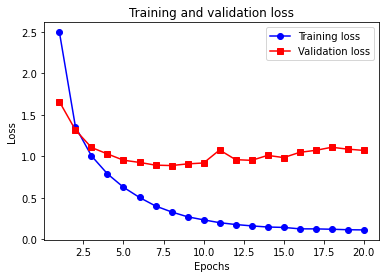

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Agora vamos plotar a acurácia durante o treinamento e validação: 

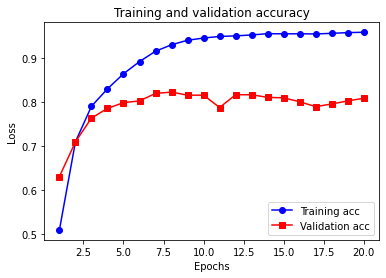

In [17]:

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Podemos perceber que durante a 9ª rodada de épocas o modelo começou a overfitar, com isso concluímos que 9 epocas é o suficiente de treinamento. Bora treinar novamente o modelo parando em 9 epocas: 

In [18]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 220us/sample - loss: 2.5193 - accuracy: 0.5294 - val_loss: 1.6386 - val_accuracy: 0.6520
Epoch 2/9
7982/7982 [==============================] - 1s 101us/sample - loss: 1.3738 - accuracy: 0.7110 - val_loss: 1.2661 - val_accuracy: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 104us/sample - loss: 1.0305 - accuracy: 0.7769 - val_loss: 1.1115 - val_accuracy: 0.7670
Epoch 4/9
7982/7982 [==============================] - 1s 98us/sample - loss: 0.8095 - accuracy: 0.8279 - val_loss: 1.0037 - val_accuracy: 0.7870
Epoch 5/9
7982/7982 [==============================] - 1s 99us/sample - loss: 0.6408 - accuracy: 0.8639 - val_loss: 0.9365 - val_accuracy: 0.7970
Epoch 6/9
7982/7982 [==============================] - 1s 98us/sample - loss: 0.5130 - accuracy: 0.8900 - val_loss: 0.9066 - val_accuracy: 0.8120
Epoch 7/9
7982/7982 [==============================] - 1s 96us/sample - l

Para avaliar o resultado, vamos rodar o modelo com a parte de teste que separamos do dataset. 

In [19]:
results = model.evaluate(x_test, one_hot_test_labels, verbose=2)
print(results)

2246/2246 - 0s - loss: 0.9937 - accuracy: 0.7898
[0.9937268730156781, 0.7898486]


A precisão é de quase 80%, o que é realmente muito bom!!

Se a classificação for sorteada aleatoriamente, a precisão do problema de classificação binária é de 50%, e a precisão da classificação para 46 categorias é inferior a 19%:

In [20]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18432769367764915

Ao chamar o método de previsão da instância do modelo, a distribuição de probabilidade da entrada em 46 categorias pode ser obtida:

In [21]:
predictions = model.predict(x_test)
predictions

array([[1.72275861e-04, 1.68348997e-04, 4.63836950e-05, ...,
        8.00226735e-06, 1.01900687e-05, 2.32556113e-06],
       [3.01082386e-03, 1.01267412e-01, 1.44674396e-03, ...,
        3.32008087e-04, 8.47177071e-05, 2.29866528e-05],
       [4.58389102e-03, 5.92218876e-01, 1.33225229e-02, ...,
        5.66237979e-03, 5.89500531e-04, 3.23004875e-04],
       ...,
       [4.80548042e-05, 1.89294369e-04, 2.25114527e-05, ...,
        1.20536615e-05, 6.79310324e-06, 2.04386129e-06],
       [2.23178230e-03, 3.54308337e-01, 9.42209084e-03, ...,
        3.22150532e-04, 1.89892249e-03, 3.75262520e-04],
       [2.95035221e-04, 6.45685315e-01, 1.07156849e-02, ...,
        2.72086152e-04, 2.55448977e-04, 1.16469775e-04]], dtype=float32)

In [22]:
# Representa a possibilidade de 46 classificações
predictions[0].shape

(46,)

In [23]:
# A soma é 1
np.sum(predictions[0])

1.0000004

In [24]:
# O maior, que achamos que esta notícia pertence a esta categoria
np.argmax(predictions[0])

3

### Outra maneira de lidar com rótulos e perdas:
Conforme mencionado anteriormente, os rótulos podem usar codificação one-hot ou processar rótulos diretamente em tensores inteiros:

In [25]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

Nesse caso, a função de perda também deve ser alterada para sparse_categorical_crossentropy, que é o mesmo matematicamente que categorical_crossentropy, mas a interface é diferente:

In [26]:
model.compile(optimizer='rmsprop',
               loss='sparse_categorical_crossentropy',
               metrics=['acc'])

A importância de uma camada intermediária suficientemente grande
Discutimos anteriormente sobre o "gargalo de informações" e, em seguida, dissemos que para esta rede de resultados de 46 dimensões, a dimensionalidade da camada intermediária deve ser grande o suficiente!

Agora vamos tentar se não é grande o suficiente (causando gargalo de informação). Vamos exagerar um pouco e reduzir de 64 para 4:

In [27]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 240us/sample - loss: 2.8907 - accuracy: 0.2814 - val_loss: 2.1078 - val_accuracy: 0.4820
Epoch 2/20
7982/7982 [==============================] - 1s 145us/sample - loss: 1.7547 - accuracy: 0.5798 - val_loss: 1.5782 - val_accuracy: 0.6130
Epoch 3/20
7982/7982 [==============================] - 1s 145us/sample - loss: 1.4202 - accuracy: 0.6206 - val_loss: 1.4513 - val_accuracy: 0.6330
Epoch 4/20
7982/7982 [==============================] - 1s 143us/sample - loss: 1.2605 - accuracy: 0.6580 - val_loss: 1.3956 - val_accuracy: 0.6600
Epoch 5/20
7982/7982 [==============================] - 1s 143us/sample - loss: 1.1267 - accuracy: 0.7132 - val_loss: 1.3265 - val_accuracy: 0.6980
Epoch 6/20
7982/7982 [==============================] - 1s 165us/sample - loss: 1.0051 - accuracy: 0.7329 - val_loss: 1.3085 - val_accuracy: 0.6990
Epoch 7/20
7982/7982 [==============================] - 1s 154us

Veja só, este treinamento não é um pouco pior do que o anterior de 64 dimensões.

Essa queda no efeito ocorre porque a dimensão espacial que você aprendeu para ele é muito baixa e ele descarta muitas informações úteis para classificação.

Quanto maior, melhor? Vamos tentar ampliar a camada do meio:

In [28]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 353us/sample - loss: 1.5480 - accuracy: 0.6315 - val_loss: 1.1160 - val_accuracy: 0.7320
Epoch 2/20
7982/7982 [==============================] - 2s 268us/sample - loss: 0.8374 - accuracy: 0.7964 - val_loss: 1.0251 - val_accuracy: 0.7610
Epoch 3/20
7982/7982 [==============================] - 2s 255us/sample - loss: 0.5120 - accuracy: 0.8738 - val_loss: 0.9627 - val_accuracy: 0.7970
Epoch 4/20
7982/7982 [==============================] - 2s 267us/sample - loss: 0.3249 - accuracy: 0.9198 - val_loss: 1.0095 - val_accuracy: 0.8010
Epoch 5/20
7982/7982 [==============================] - 2s 251us/sample - loss: 0.2273 - accuracy: 0.9421 - val_loss: 1.2236 - val_accuracy: 0.8040
Epoch 6/20
7982/7982 [==============================] - 2s 254us/sample - loss: 0.1829 - accuracy: 0.9490 - val_loss: 1.3214 - val_accuracy: 0.7840
Epoch 7/20
7982/7982 [==============================] - 2s 244us

Percebe-se que o tempo de treinamento foi um pouco mais longo, e o computador esquentou um pouco, mas o efeito não melhorou muito. Isso ocorre porque a entrada da primeira camada para a camada do meio tem apenas 64 dimensões. Não importa quão grande seja a camada do meio, ela é restrita pelo gargalo da primeira camada.

Vamos tentar aumentar a primeira camada também!

In [29]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 8s 967us/sample - loss: 1.3473 - accuracy: 0.6969 - val_loss: 0.9965 - val_accuracy: 0.7700
Epoch 2/20
7982/7982 [==============================] - 6s 769us/sample - loss: 0.5329 - accuracy: 0.8814 - val_loss: 0.8300 - val_accuracy: 0.8060
Epoch 3/20
7982/7982 [==============================] - 6s 759us/sample - loss: 0.2796 - accuracy: 0.9352 - val_loss: 1.1440 - val_accuracy: 0.7360
Epoch 4/20
7982/7982 [==============================] - 6s 754us/sample - loss: 0.2072 - accuracy: 0.9460 - val_loss: 0.9644 - val_accuracy: 0.7960
Epoch 5/20
7982/7982 [==============================] - 6s 780us/sample - loss: 0.1664 - accuracy: 0.9501 - val_loss: 1.0272 - val_accuracy: 0.8160
Epoch 6/20
7982/7982 [==============================] - 6s 755us/sample - loss: 0.1431 - accuracy: 0.9543 - val_loss: 1.0107 - val_accuracy: 0.8250
Epoch 7/20
7982/7982 [==============================] - 6s 763us

Um pouco menor, originalmente usado 4096, mas é muito grande

Vamos plotar um gráfico para avaliar melhor o resultado: 

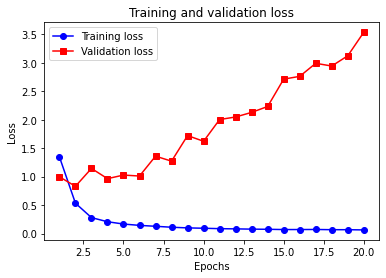

In [30]:

import matplotlib.pyplot as plt

loss = _.history['loss']
val_loss = _.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Portanto, muito grande não é bom. 

Vamos tentar usar menos camadas:

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 198us/sample - loss: 2.4874 - accuracy: 0.5862 - val_loss: 1.8713 - val_accuracy: 0.6470
Epoch 2/20
7982/7982 [==============================] - 1s 128us/sample - loss: 1.4303 - accuracy: 0.7141 - val_loss: 1.3829 - val_accuracy: 0.7010
Epoch 3/20
7982/7982 [==============================] - 1s 128us/sample - loss: 0.9820 - accuracy: 0.7894 - val_loss: 1.1543 - val_accuracy: 0.7630
Epoch 4/20
7982/7982 [==============================] - 1s 129us/sample - loss: 0.7301 - accuracy: 0.8504 - val_loss: 1.0398 - val_accuracy: 0.7840
Epoch 5/20
7982/7982 [==============================] - 1s 131us/sample - loss: 0.5795 - accuracy: 0.8824 - val_loss: 0.9856 - val_accuracy: 0.7950
Epoch 6/20
7982/7982 [==============================] - 1s 130us/sample - loss: 0.4796 - accuracy: 0.9032 - val_loss: 0.9617 - val_accuracy: 0.7980
Epoch 7/20
7982/7982 [==============================] - 1s 134us

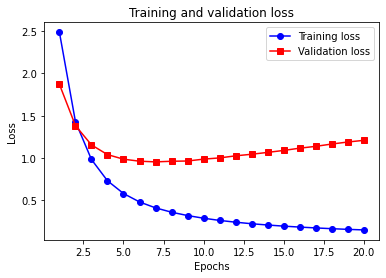

In [31]:
model = models.Sequential()
model.add(layers.Dense(46, activation='softmax', input_shape=(10000,)))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Vamos! O resultado é um pouco pior.

Agora usando Mais camadas

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 250us/sample - loss: 1.8284 - accuracy: 0.5811 - val_loss: 1.2636 - val_accuracy: 0.7000
Epoch 2/20
7982/7982 [==============================] - 1s 146us/sample - loss: 1.0526 - accuracy: 0.7493 - val_loss: 1.1824 - val_accuracy: 0.7160
Epoch 3/20
7982/7982 [==============================] - 1s 153us/sample - loss: 0.7345 - accuracy: 0.8301 - val_loss: 1.0298 - val_accuracy: 0.7730
Epoch 4/20
7982/7982 [==============================] - 1s 155us/sample - loss: 0.5163 - accuracy: 0.8827 - val_loss: 1.0095 - val_accuracy: 0.8010
Epoch 5/20
7982/7982 [==============================] - 1s 156us/sample - loss: 0.3664 - accuracy: 0.9179 - val_loss: 1.1162 - val_accuracy: 0.7720
Epoch 6/20
7982/7982 [==============================] - 1s 156us/sample - loss: 0.2792 - accuracy: 0.9365 - val_loss: 1.2895 - val_accuracy: 0.7630
Epoch 7/20
7982/7982 [==============================] - 1s 174us

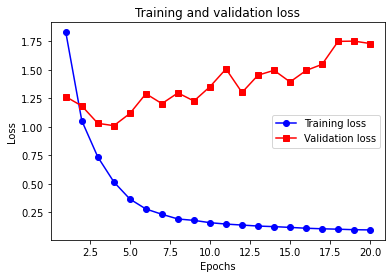

In [32]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Então podemos concluir que nem sempre mais é melhor, mas também menos não quer dizer pior. ;) 